In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime

In [3]:
dat=pd.read_csv('NASDAQOMX-NDX.csv')

In [5]:
dat=dat.iloc[::-1]
dat.dropna(inplace=True)
dat = dat.reset_index(drop = True)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [6]:
date = dat[['Trade Date']]
dat.drop('Trade Date',inplace=True,axis=1)
dat=pd.concat([date,dat],axis=1)
dat['Trade Date'] = pd.to_datetime(dat['Trade Date'],format='%Y-%m-%d')

C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


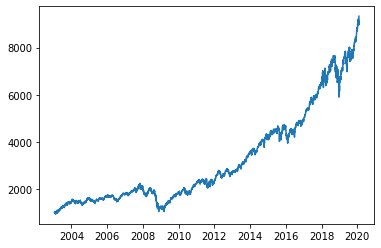

In [8]:
plt.plot(dat['Trade Date'],dat["Index Value"])

In [9]:
def typical(high,low,close,volume):
    mf = ((high + low + close)/3)*volume
    return mf     

In [10]:
#EMA
def EMA(data):
    dats = data.astype(float)
    data['EMA'] = dats.ewm(span = 20).mean()
    return data['EMA']

In [11]:
def MFI(data):
    data = pd.DataFrame(data)
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    
    mfi = 100 - (100/(1+(upm/downm)))
    return mfi

In [12]:
#RSI
def RSI(data):
    data = pd.DataFrame(data)
    returns = data - data.shift(1)
    returns.dropna()
    up,down = returns.copy(),returns.copy()
    up[up<0] = 0
    down[down>0] = 0
    upm = up.mean()
    downm = down.abs().mean()
    rsi = 100 - (100/(1+(upm/downm)))
    return rsi 

In [13]:
def MACD(ema):
    high = 0.075 * ema
    low = 0.15 * ema
    macd = high - low
    return macd

In [14]:
def Oscillator(data):

    curr = data[-1]
    data = list(data)
    high = max(data)
    low = min(data)
    so = ((curr - low)/(high - low))*100 
    return so

In [15]:
dat['MF'] = typical(dat['High'],dat['Low'],dat['Index Value'],dat['Total Market Value'])

In [16]:
dat['EMA'] = EMA(dat.iloc[:,[3]])

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [17]:
dat['RSI'] = dat['Index Value'].rolling(7).apply(RSI)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [18]:
dat['MFI'] = dat['MF'].rolling(7).apply(MFI)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [19]:
dat['SO'] = dat['Index Value'].rolling(7).apply(Oscillator)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


In [20]:
dat.index=date["Trade Date"]

In [22]:
dat['MACD'] = MACD(dat.iloc[:,[7]])

In [23]:
dat['MACD_Signal'] = MACD(dat.iloc[:,[11]])

In [24]:
dat.drop(['High','Low','Total Market Value','Dividend Market Value','MF','MACD_Signal'],axis = 1,inplace = True)

In [25]:
dat.drop("Trade Date",axis=1,inplace=True)

In [26]:
xdata = dat.dropna()

In [27]:
dates = xdata.copy()

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xdata = pd.DataFrame(scaler.fit_transform(xdata))

In [31]:
xdata = xdata.rename({0:'Index Value',1:'EMA',2:'RSI',3:'MFI',4:'SO',5:'MACD'},axis = 1)

In [32]:
xdata.index = dates.index

In [33]:
ydata = xdata['Index Value'].shift(-1)

In [34]:
xdata = xdata.drop('Index Value',axis = 1)

In [36]:
x_trains, y_trains = xdata[:3000],ydata[:3000]

In [37]:
y_trains = pd.DataFrame(y_trains)

In [38]:
x_tests, y_tests = xdata[3000:],ydata[3000:]

In [39]:
y_tests = pd.DataFrame(y_tests)

In [40]:
y_tests.dropna(inplace = True)

In [43]:
x_tests  = x_tests[:-1]

In [44]:
xdata  = xdata[:-1]

In [45]:
ydata.dropna(inplace = True)

In [48]:
from __future__ import division
import random
import math
import time

In [49]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from scipy.sparse import linalg


class LSSVR(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=10,polyconst=1,degree=2):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.polyconst = float(1)
        self.gamma = float(gamma)
        self.degree = degree
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        #t = pd.DataFrame(t)                      #Comment this line while running main function, nd run this block again uncommenting this line when running optimizer fn. 
        t[1:n] = self.supportVectorLabels.values
    
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias
    
    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
            #k = np.exp(-1.0*self.gamma*np.dot(np.subtract(v,u).T,np.subtract(v,u))) #rbf expression
        if kernel == 'polynomial':
            k = (np.dot(u,v.T) + self.polyconst)**self.degree

            
        return k

In [50]:
"""Least Squares Support Vector Regression."""
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.gaussian_process import kernels
from scipy.sparse import linalg


class LSSVR1(BaseEstimator, RegressorMixin):
    def __init__(self, C=None, kernel=None, gamma=10,polyconst=1,degree=2):
        self.supportVectors      = None
        self.supportVectorLabels = None
        self.C = C
        self.polyconst = float(1)
        self.gamma = float(gamma)
        self.degree = degree
        self.kernel= kernel
        self.idxs  = None
        self.K = None
        self.bias = None 
        self.alphas = None
            

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, x_train, y_train):
        
        if type(self.idxs) == type(None):
            self.idxs=np.full(x_train.shape[0],True, dtype=bool)
            
             
        self.supportVectors      = x_train.loc[self.idxs, :]
        self.supportVectorLabels = y_train.loc[self.idxs]
               
        K = self.kernel_func(self.kernel, x_train, self.supportVectors, self.gamma)
        
        self.K = K
        OMEGA = K
        OMEGA[self.idxs, np.arange(OMEGA.shape[1])] =OMEGA[self.idxs, np.arange(OMEGA.shape[1])] + 1/self.C
        
        D = np.zeros(np.array(OMEGA.shape) + 1)
        D[1:,1:] = OMEGA
        D[0, 1:] += 1
        D[1:,0 ] += 1

        n = len(self.supportVectorLabels) + 1
        t = np.zeros(n)
        t = pd.DataFrame(t)                      #Comment this line while running main function, nd run this block again uncommenting this line when running optimizer fn. 
        t[1:n] = self.supportVectorLabels.values
    
    
        try:
            z = linalg.lsmr(D.T, t)[0]
        except:
            z = np.linalg.pinv(D).T @ t.ravel()

        self.bias   = z[0]
        self.alphas = z[1:]
        self.alphas = self.alphas[self.idxs]

        return self

    def predict(self, x_test):
        K = self.kernel_func(self.kernel, x_test, self.supportVectors, self.gamma)

        return (K @ self.alphas) + self.bias
    
    def kernel_func(self, kernel, u, v, gamma):
        if kernel == 'linear':
            k = np.dot(u, v.T)
        if kernel == 'rbf':
            k = rbf_kernel(u, v, gamma=gamma)
            #k = np.exp(-1.0*self.gamma*np.dot(np.subtract(v,u).T,np.subtract(v,u))) #rbf expression
        if kernel == 'polynomial':
            k = (np.dot(u,v.T) + self.polyconst)**self.degree

            
        return k

In [51]:
class salp:
    def __init__(self,bounds):
        self.position = []
        self.fitness = -1

        for i in range(0,n_dim):
            self.position.append(random.uniform(bounds[i][0],bounds[i][1]))
    
    def evaluate(self,costFunc):
        self.fitness = costFunc(self.position)
        
    def update_leader(self,F,c1,bounds):
        for i in range(0,n_dim):
            c2 = random.random()
            c3 = random.random()
            
            if c3 >=0.5:
                self.position[i] = F[i] + c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
            elif c3<0.5:
                self.position[i] = F[i] - c1*(c2*(bounds[i][1] - bounds[i][0]) + bounds[i][0])
                
            if self.position[i]>bounds[i][1]:
                self.position[i]=bounds[i][1]

            if self.position[i] < bounds[i][0]:
                self.position[i]=bounds[i][0] 
                
                     
                
class SSA():
    def __init__(self,costFunc,bounds,salp_size,maxiter):
        global n_dim
        
        n_dim = len(bounds)
        F_pos = []
        F_val = -1
        
        salps = []
        for i in range(0,salp_size):
            salps.append(salp(bounds))
            
        i = 0
        while i < maxiter:
            
            c1 = 2*math.exp(-((4*i)/maxiter)**2)
            
            for j in range(0,salp_size):
                salps[j].evaluate(costFunc)
                if salps[j].fitness < F_val or F_val == -1:
                    F_val = salps[j].fitness
                    F_pos = list(salps[j].position)
            
            for j in range(0,salp_size):        
                if j == 1:
                    salps[j].update_leader(F_pos,c1,bounds)
                else :
                    for k in range(0,n_dim):
                        salps[j].position[k] = (salps[j].position[k] + salps[j-1].position[k])/2
                        if salps[j].position[k]>bounds[k][1]:
                            salps[j].position[k]=bounds[k][1]

                        if salps[j].position[k] < bounds[k][0]:
                            salps[j].position[k]=bounds[k][0]    
            i = i+1 
            
        print (F_pos)
        print (F_val)    
            

In [52]:
from sklearn.model_selection import TimeSeriesSplit

In [53]:
fold_count=10 

def load_csvdata():
    global X
    global Y
    
    X = xdata
    Y = ydata

def svrPso(params):
    kf = TimeSeriesSplit(n_splits=fold_count)
    for train, test in kf.split(X):
        Total = 0
         
        X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], Y.iloc[train], Y.iloc[test]
        nn = LSSVR(kernel = 'rbf',C=params[0], gamma = params[1])#Change Kernel name here(for poly kernel add 2 more parameters to optimize[degree,polyconst])
        nn.fit(X_train,y_train)
        result = nn.predict(X_test);
        thisError = calsError(y_test, result)
        Total = Total + thisError    
    ErrorCV = Total/fold_count; 
    print('Optimizing the Parameters ..... C = {c}, gamma={e}, MSE={m}'.format(c=params[0], e=params[1], m=ErrorCV))
    return ErrorCV

def calsError(y_test, result):
    y_pred = pd.DataFrame(result)
    y_pred.index = y_test.index
    data = pd.concat([y_test,y_pred],axis=1)
    data['Error'] = (data['Index Value'] - data[0])**2
    err = np.sqrt(np.sum(data['Error']))
    
    return err
    
def main_run():
    
        load_csvdata()
        #For SSA
        bounds=[(0.01,5000),(0.0002,500)] 
        SSA(svrPso,bounds,salp_size=5,maxiter=100)
        
        
        print(" ")
        print("************ Objective Function optimized *****************")
        print(" ")
        print(" ")

In [54]:
print("************  Initializing Optimization *****************")
tic = time.time()
main_run()
toc = time.time()
print("************  Optimization Finished *****************")
print('Time Taken is {time} secs'.format(time = (toc - tic)))

In [66]:
model = LSSVR1(kernel='rbf',C =F_pos[0],gamma =F_pos[1])
model.fit(x_trains,y_trains)

LSSVR1(C=5000, degree=2, gamma=0.0002, kernel='rbf', polyconst=1.0)

In [67]:
res = model.predict(x_tests)
res = pd.DataFrame(res)
res.index = y_tests.index
res.rename({0:'Index value'},axis =1,inplace=True)

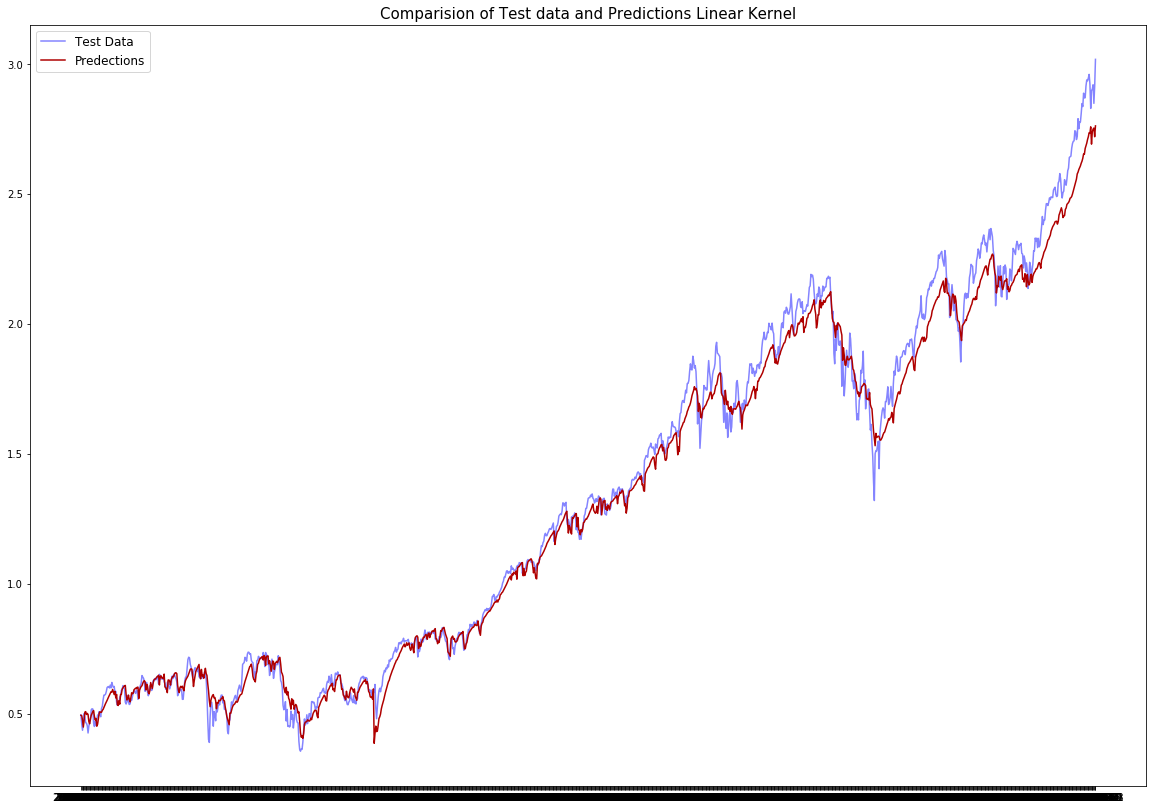

In [58]:
plt.figure(figsize = (20,14))
plt.plot(y_tests,color="#0A0AFF",alpha=0.5,label="Test Data")
plt.plot(res,color="#AF0000",label="Predections")
plt.title("Comparision of Test data and Predictions Linear Kernel",fontsize=15)
plt.legend(fontsize="large")